In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
# Load MNIST and split into two domains
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
x_train = (x_train.astype("float32") - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
domain_A = x_train[y_train < 5]   # digits 0-4
domain_B = x_train[y_train >= 5]  # digits 5-9

In [4]:
# Simple generator
def build_generator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, 3, padding="same", activation="relu", input_shape=(28,28,1)),
        layers.Conv2DTranspose(1, 3, padding="same", activation="tanh")
    ])
    return model

In [5]:
# Simple discriminator
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, 3, strides=2, padding="same", input_shape=(28,28,1)),
        layers.LeakyReLU(0.2),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

In [6]:
G_AB = build_generator()
G_BA = build_generator()
D_A = build_discriminator()
D_B = build_discriminator()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
D_A.compile(optimizer="adam", loss="binary_crossentropy")
D_B.compile(optimizer="adam", loss="binary_crossentropy")

In [8]:
# Cycle loss
cycle_loss = tf.keras.losses.MeanAbsoluteError()

In [12]:
# One step training
batch_size = 128
for epoch in range(50):
    idx_A = np.random.randint(0, domain_A.shape[0], batch_size)
    idx_B = np.random.randint(0, domain_B.shape[0], batch_size)
    real_A, real_B = domain_A[idx_A], domain_B[idx_B]

    fake_B = G_AB.predict(real_A)
    fake_A = G_BA.predict(real_B)

    D_A.train_on_batch(real_A, np.ones((batch_size,1)))
    D_A.train_on_batch(fake_A, np.zeros((batch_size,1)))
    D_B.train_on_batch(real_B, np.ones((batch_size,1)))
    D_B.train_on_batch(fake_B, np.zeros((batch_size,1)))

    # cycle consistency
    reconstructed_A = G_BA.predict(fake_B)
    reconstructed_B = G_AB.predict(fake_A)
    c_loss = cycle_loss(real_A, reconstructed_A) + cycle_loss(real_B, reconstructed_B)

    print(f"Epoch {epoch+1} | Cycle loss: {c_loss:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 1 | Cycle loss: 1.8696
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Epoch 2 | Cycle loss: 1.8670
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Epoch 3 | Cycle loss: 1.8677
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 4 | Cycle loss: 1.8699
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Epoch 5 | Cycle loss: 1.8693
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━

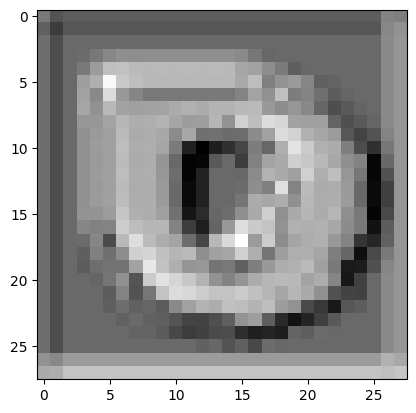

In [13]:
plt.imshow(fake_B[0].reshape(28,28), cmap="gray")
plt.show()